# Analisis Sentimen Ulasan Aplikasi SIREKAP
**Kerja Praktik – KPU Provinsi Jawa Timur**
1. Pengambilan data ulasan dari Google Play  
2. Eksplorasi dan deskripsi dataset  
3. Pra-pemrosesan teks  
4. Representasi data menggunakan TF-IDF  
5. Model Naive Bayes


## Scraping

In [1]:
#%pip install google-play-scraper pandas numpy matplotlib scikit-learn sastrawi emoji joblib nltk wordcloud

### Init

In [2]:
from google_play_scraper import Sort, reviews
import pandas as pd
from pathlib import Path
import json, time
from wordcloud import WordCloud
import matplotlib.pyplot as plt


### Configuration

In [3]:
#Configuration

APP_ID   = "id.go.kpu.sirekap2024"
LANG     = "id"
COUNTRY  = "id"
SORTING  = Sort.MOST_RELEVANT
MAX_ROWS = 20000
BATCH    = 200
SLEEP    = 1.0

DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)
CSV_PATH = DATA_DIR / "raw_reviews.csv"
CSV_STD  = DATA_DIR / "raw_reviews_standard.csv"
STATE    = DATA_DIR / "scrape_state.json"


In [4]:
#Helper Function

def load_state():
    if STATE.exists():
        try:
            return json.loads(STATE.read_text())
        except:
            return {}
    return {}

def save_state(obj):
    token = obj.get("continuation_token")
    if token is not None:
        try:
            token = token.token
        except AttributeError:
            token = str(token)
    obj["continuation_token"] = token
    STATE.write_text(json.dumps(obj))


### Start Scraping & Save CSV

In [5]:
# Load file lama jika sudah ada
if CSV_PATH.exists():
    df_all = pd.read_csv(CSV_PATH)
    print(f"Memuat {len(df_all):,} baris dari file sebelumnya.")
else:
    df_all = pd.DataFrame()

continuation_token = None
batch_num = 0

print("Mulai scraping ulasan aplikasi SIREKAP ...")

try:
    while len(df_all) < MAX_ROWS:
        batch_num += 1
        print(f"\nBatch #{batch_num} — total saat ini: {len(df_all):,}")

        result, continuation_token = reviews(
            APP_ID, lang=LANG, country=COUNTRY, sort=SORTING,
            count=BATCH, continuation_token=continuation_token
        )

        if not result:
            print("Tidak ada hasil lagi dari Play Store.")
            break

        df_batch = pd.DataFrame(result)
        before = len(df_all)
        df_all = pd.concat([df_all, df_batch], ignore_index=True)
        df_all.drop_duplicates(subset=["reviewId"], inplace=True)
        after = len(df_all)
        fetched_now = max(0, after - before)

        print(f"Batch {batch_num}: {fetched_now} baru | total unik: {len(df_all)}")
        df_all.to_csv(CSV_PATH, index=False)

        if continuation_token is None:
            print("Selesai — tidak ada continuation_token lagi.")
            break

        time.sleep(SLEEP)

    print(f"\nScraping selesai. Total review unik: {len(df_all):,}")

except KeyboardInterrupt:
    print("\nDihentikan manual. Menyimpan progress ...")
    df_all.to_csv(CSV_PATH, index=False)

Mulai scraping ulasan aplikasi SIREKAP ...

Batch #1 — total saat ini: 0
Batch 1: 200 baru | total unik: 200

Batch #2 — total saat ini: 200
Batch 2: 200 baru | total unik: 400

Batch #3 — total saat ini: 400
Batch 3: 200 baru | total unik: 600

Batch #4 — total saat ini: 600
Batch 4: 200 baru | total unik: 800

Batch #5 — total saat ini: 800
Batch 5: 200 baru | total unik: 1000

Batch #6 — total saat ini: 1,000
Batch 6: 200 baru | total unik: 1200

Batch #7 — total saat ini: 1,200
Batch 7: 200 baru | total unik: 1400

Batch #8 — total saat ini: 1,400
Batch 8: 200 baru | total unik: 1600

Batch #9 — total saat ini: 1,600
Batch 9: 200 baru | total unik: 1800

Batch #10 — total saat ini: 1,800
Batch 10: 200 baru | total unik: 2000

Batch #11 — total saat ini: 2,000
Batch 11: 200 baru | total unik: 2200

Batch #12 — total saat ini: 2,200
Batch 12: 200 baru | total unik: 2400

Batch #13 — total saat ini: 2,400
Batch 13: 200 baru | total unik: 2600

Batch #14 — total saat ini: 2,600
Batch 1

### Normalize

In [6]:
kolom_penting = [
    "reviewId","userName","content","score","thumbsUpCount",
    "reviewCreatedVersion","appVersion","at","replyContent","repliedAt"
]
df_std = df_all[[c for c in kolom_penting if c in df_all.columns]].copy()

df_std = df_std.rename(columns={
    "userName": "user",
    "content": "review_text",
    "score": "rating",
    "thumbsUpCount": "thumbs_up",
    "at": "review_date"
})
df_std = df_std.dropna(subset=["review_text","rating"])
df_std.to_csv(CSV_STD, index=False)
print(f"Disimpan ke {CSV_STD.resolve()} | Total {len(df_std):,} baris")
df_std.head()


Disimpan ke D:\Dhanar\VS Code\Kerja Praktek\pastel-sentiment-glow\data\raw_reviews_standard.csv | Total 20,000 baris


,reviewId,user,review_text,rating,thumbs_up,reviewCreatedVersion,appVersion,review_date,replyContent,repliedAt
0,35fd099f-e115-4f0f-b95d-32de5f0fdd62,Bbirong Dan,"Aplikasi butut, herannya kpu dikasih waktu 5 t...",1,386,2.32,2.32,2024-02-26 20:47:32,None,None
1,09c34494-6046-470a-a946-9a376616f682,syahrul ramadhan,Sebelumnya saya ingin mengapresiasi digitalisa...,2,658,2.30,2.30,2024-02-01 12:45:55,None,None
2,cecae6f3-b000-42b3-aaa0-b13bbb7bcafe,Khoirul Tamam,"APLIKASI GAGAL. Suka nge bug, over akses bikin...",1,609,2.41,2.41,2024-02-16 19:29:00,None,None
3,ecef59a5-9700-4498-9926-6edf150b4d06,Purwanto “ipunk_pwt”,Lebih ke kemampuan server juga si sepertinya.....,5,0,None,None,2024-11-20 17:03:36,None,None
4,e36391d8-6e1e-4c4a-b9ed-998d0e1c926f,Mae,"Apk apaan, kalo bikin mah jangan setengah-sete...",1,0,2.41,2.41,2024-02-16 23:33:22,None,None


## Pre-Processing Data

### Init

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import re, emoji
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import numpy as np

import nltk

nltk.download('punkt')
nltk.download('punkt_tab')


from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### EDA

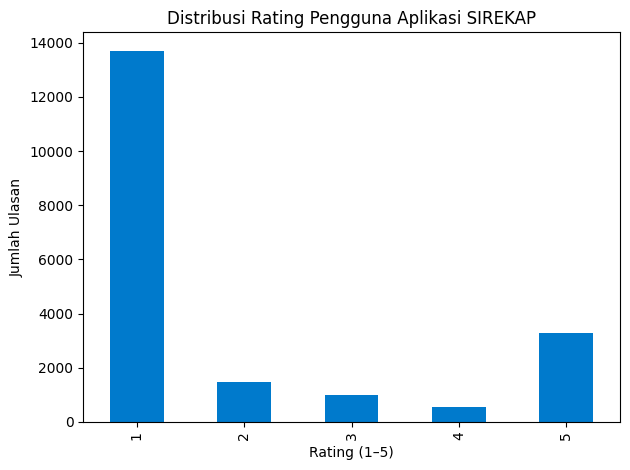

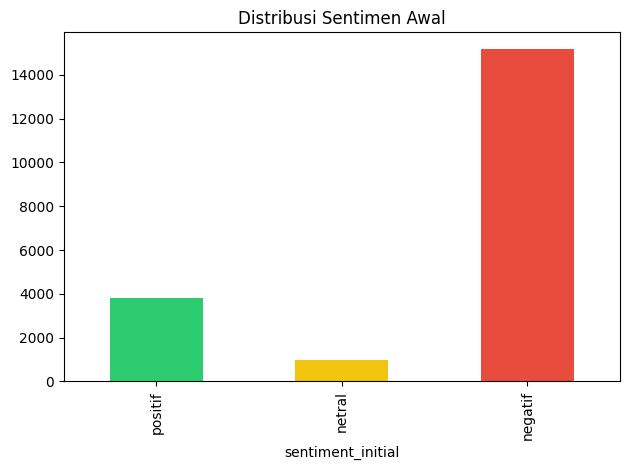

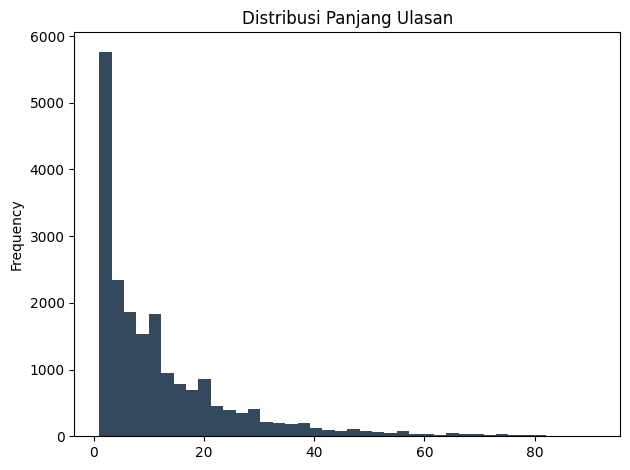

In [8]:
# Baca data
df = pd.read_csv(CSV_STD)

# Ubah tipe dan buat kolom tambahan
df["rating"] = df["rating"].astype(int)
df["sentiment_initial"] = df["rating"].apply(lambda r: "negatif" if r <= 2 else "netral" if r == 3 else "positif")
df["text_len"] = df["review_text"].astype(str).apply(lambda x: len(x.split()))

# --- Distribusi rating ---
ax = df["rating"].value_counts().sort_index().plot(kind="bar", color="#007acc")
ax.set_xlabel("Rating (1–5)")
ax.set_ylabel("Jumlah Ulasan")
ax.set_title("Distribusi Rating Pengguna Aplikasi SIREKAP")
plt.tight_layout()
plt.show()

# --- Distribusi sentimen ---
ax = df["sentiment_initial"].value_counts().reindex(["positif","netral","negatif"]).plot(
    kind="bar",
    color=["#2ecc71","#f1c40f","#e74c3c"]
)
ax.set_title("Distribusi Sentimen Awal")
plt.tight_layout()
plt.show()

# --- Distribusi panjang ulasan ---
ax = df["text_len"].plot(kind="hist", bins=40, color="#34495e")
ax.set_title("Distribusi Panjang Ulasan")
plt.tight_layout()
plt.show()


### Pre-Processing Teks

In [ ]:
# === Inisialisasi komponen ===
stemmer = StemmerFactory().create_stemmer()
stop_factory = StopWordRemoverFactory()
stopwords = set(stop_factory.get_stop_words())

# 🔑 Pertahankan kata negasi/pengubah
negation_words = {"tidak", "bukan", "kurang", "belum", "tak"}
stopwords = stopwords - negation_words

import re
URL_RE = re.compile(r"http\S+|www\.\S+")

# allow underscore karena kita akan bikin token emo_senang, emo_marah, dst
NON_ALPHA = re.compile(r"[^a-z_\s]")

# --- Emoji extraction (butuh package `emoji`) ---
import emoji
from collections import Counter

# mapping sederhana emoji -> emosi (boleh kamu tambah)
EMO_MAP = {
    "senang": {"😀","😃","😄","😁","😆","😊","🙂","😍","🥰","😂","🤣","😅","😇","😘","😋","😎","🤩","🥳","👍","👏","❤️","💙","💚","💛","💜","🤗"},
    "marah":  {"😡","😠","🤬","😤","👿","💢"},
    "sedih":  {"😢","😭","☹️","🙁","😞","😔","😟","😿","💔"},
    "takut":  {"😨","😰","😱","😳","😖","😣"},
    "jijik":  {"🤢","🤮","😷"},
    "kaget":  {"😲","😮","😯","😧","🤯"},
}

def _emoji_to_emotion(e: str) -> str:
    for emo, s in EMO_MAP.items():
        if e in s:
            return emo
    return "lainnya"

def extract_emoji_tokens_and_label(text: str):
    """
    return:
    - tokens: list token seperti ['emo_senang','emo_marah']
    - label: emosi dominan ('senang','marah',...) atau 'tanpa_emoji'
    """
    if not isinstance(text, str) or text.strip() == "":
        return [], "tanpa_emoji"

    ems = [d["emoji"] for d in emoji.emoji_list(text)]
    if not ems:
        return [], "tanpa_emoji"

    emos = [_emoji_to_emotion(e) for e in ems]
    tokens = [f"emo_{e}" for e in emos]

    top = Counter(emos).most_common(1)[0][0]
    return tokens, top

def simple_preprocess(text):
    if not isinstance(text, str) or text.strip() == "":
        return ""

    # 1) ambil info emoji dulu (sebelum dibersihkan)
    emo_tokens, _ = extract_emoji_tokens_and_label(text)

    # 2) normalisasi dasar
    text = text.lower()
    text = URL_RE.sub(" ", text)

    # 3) hapus emoji dari teks (karena sudah diubah jadi token)
    text = emoji.replace_emoji(text, replace=" ")

    # 4) bersihkan selain huruf (underscore tetap)
    text = NON_ALPHA.sub(" ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # 5) tokenisasi sederhana (tanpa nltk biar ringan)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords and len(t) > 1]

    # 6) stemming + gabungkan token emoji
    tokens = [stemmer.stem(t) for t in tokens]
    tokens = tokens + emo_tokens

    return " ".join(tokens)


# === Jalankan pada dataset ===
df = pd.read_csv("data/raw_reviews_standard.csv")
df["rating"] = df["rating"].astype(int)
df["sentiment_initial"] = df["rating"].apply(lambda r: "negatif" if r <= 2 else "netral" if r == 3 else "positif")

# kolom tambahan khusus emoji
tmp = df["review_text"].apply(extract_emoji_tokens_and_label)
df["emoji_tokens"]  = tmp.apply(lambda x: " ".join(x[0]))
df["emoji_emotion"] = tmp.apply(lambda x: x[1])

tqdm.pandas(desc="Preprocessing")
df["clean_text"] = df["review_text"].progress_apply(simple_preprocess)

df = df[df["clean_text"].str.strip() != ""].drop_duplicates(subset=["clean_text"])
df.to_csv("data/clean_reviews.csv", index=False)

print("Selesai, disimpan ke data/clean_reviews.csv")
print(df[["review_text","emoji_tokens","emoji_emotion","clean_text"]].head(5))


Preprocessing: 100%|██████████| 20000/20000 [33:05<00:00, 10.07it/s] 


Selesai, disimpan ke data/clean_reviews.csv
                                         review_text emoji_tokens  \
0  Aplikasi butut, herannya kpu dikasih waktu 5 t...                
1  Sebelumnya saya ingin mengapresiasi digitalisa...                
2  APLIKASI GAGAL. Suka nge bug, over akses bikin...                
3  Lebih ke kemampuan server juga si sepertinya.....                
4  Apk apaan, kalo bikin mah jangan setengah-sete...                

  emoji_emotion                                         clean_text  
0   tanpa_emoji  aplikasi butut heran kpu kasih waktu tahun bua...  
1   tanpa_emoji  belum apresiasi digitalisasi dlm aspek yg kait...  
2   tanpa_emoji  aplikasi gagal suka nge bug over akses bikin l...  
3   tanpa_emoji  lebih mampu server si seperti aplikasi jauh ke...  
4   tanpa_emoji  apk apa kalo bikin mah jangan tengah tengah ka...  


### Thumbs Up

                       n  mean  median  p90   max
sentiment_initial                                
negatif            13543  5.16     0.0  1.0  8435
netral               856  5.32     0.0  1.0  3013
positif             2201  2.27     0.0  1.0   462


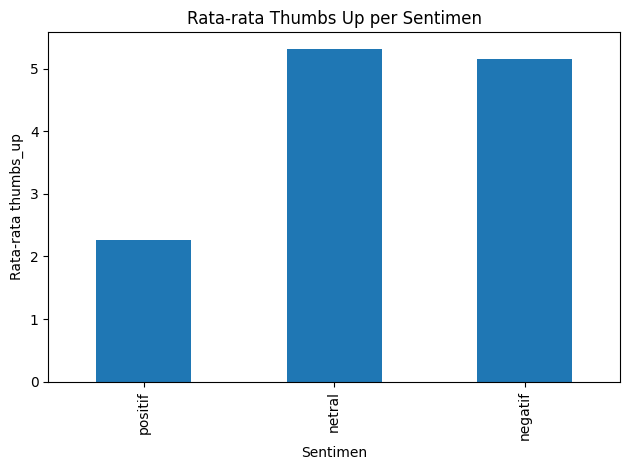

In [30]:
import numpy as np

df = pd.read_csv("data/clean_reviews.csv")
df["thumbs_up"] = pd.to_numeric(df["thumbs_up"], errors="coerce").fillna(0).astype(int)

thumb_summary = df.groupby("sentiment_initial")["thumbs_up"].agg(
    n="count",
    mean="mean",
    median="median",
    p90=lambda x: np.percentile(x, 90),
    max="max"
).round(2)

print(thumb_summary)

top_by_sent = (df.sort_values("thumbs_up", ascending=False)
                 .groupby("sentiment_initial")
                 .head(5)[["sentiment_initial","thumbs_up","rating","review_text"]])

top_by_sent

import matplotlib.pyplot as plt

means = df.groupby("sentiment_initial")["thumbs_up"].mean().reindex(["positif","netral","negatif"])
means.plot(kind="bar")
plt.title("Rata-rata Thumbs Up per Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Rata-rata thumbs_up")
plt.tight_layout()
plt.savefig("images/thumbs_up_by_sentiment.png", dpi=200)
plt.show()



### Emoji

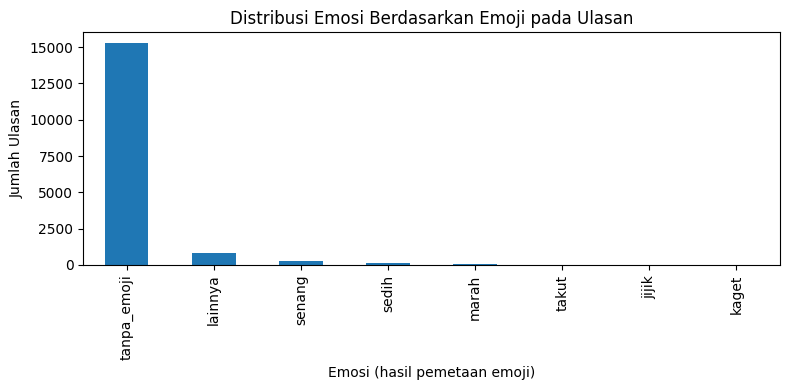

In [31]:
import matplotlib.pyplot as plt

# pastikan kolom emoji_emotion ada
df = pd.read_csv("data/clean_reviews.csv")
if "emoji_emotion" not in df.columns:
    raise KeyError("Kolom emoji_emotion belum ada. Pastikan preprocessing emoji sudah dijalankan.")

emo_counts = df["emoji_emotion"].value_counts()

plt.figure(figsize=(8,4))
emo_counts.plot(kind="bar")
plt.title("Distribusi Emosi Berdasarkan Emoji pada Ulasan")
plt.xlabel("Emosi (hasil pemetaan emoji)")
plt.ylabel("Jumlah Ulasan")
plt.tight_layout()
plt.savefig("images/distribusi_emoji_emotion.png", dpi=200)
plt.show()


### TF-IDF

In [10]:
# Pastikan folder artifacts ada
Path("artifacts").mkdir(exist_ok=True)

# Validasi kolom clean_text
if "clean_text" not in df.columns:
    raise KeyError("Kolom 'clean_text' tidak ditemukan di dataset!")

# Inisialisasi vectorizer
tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,3),
    min_df=2,
    sublinear_tf=True,
    smooth_idf=True
)

X_tfidf = tfidf.fit_transform(df["clean_text"])
y = df["sentiment_initial"]

joblib.dump(tfidf, "artifacts/tfidf_vectorizer.pkl")

print("Dimensi TF-IDF:", X_tfidf.shape)


Dimensi TF-IDF: (16600, 30000)


### Dominant Word

In [11]:
def top_terms_by_class(mask, X, vectorizer, topk=500):
    mean_scores = np.asarray(X[mask].mean(axis=0)).ravel()
    idx = mean_scores.argsort()[::-1][:topk]
    vocab = np.array(vectorizer.get_feature_names_out())
    return pd.DataFrame({"term": vocab[idx], "mean_tfidf": mean_scores[idx].round(6)})

mask_pos = (df["sentiment_initial"]=="positif").values
mask_net = (df["sentiment_initial"]=="netral").values
mask_neg = (df["sentiment_initial"]=="negatif").values

top_pos = top_terms_by_class(mask_pos, X_tfidf, tfidf)
top_net = top_terms_by_class(mask_net, X_tfidf, tfidf)
top_neg = top_terms_by_class(mask_neg, X_tfidf, tfidf)

pd.concat([
    top_pos.assign(class_="positif"),
    top_net.assign(class_="netral"),
    top_neg.assign(class_="negatif")
]).to_csv("artifacts/vocab_top_terms.csv", index=False)

print("✅ Top terms disimpan di artifacts/vocab_top_terms.csv")


✅ Top terms disimpan di artifacts/vocab_top_terms.csv


### Word Cloud

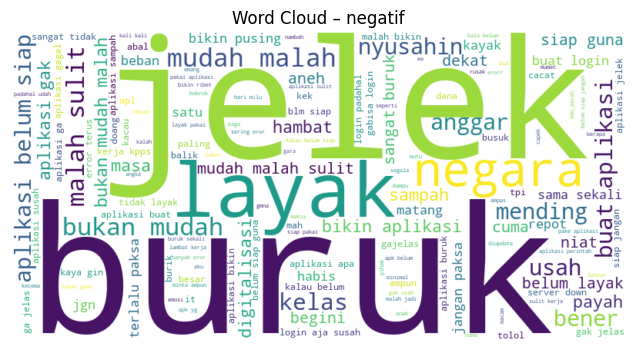

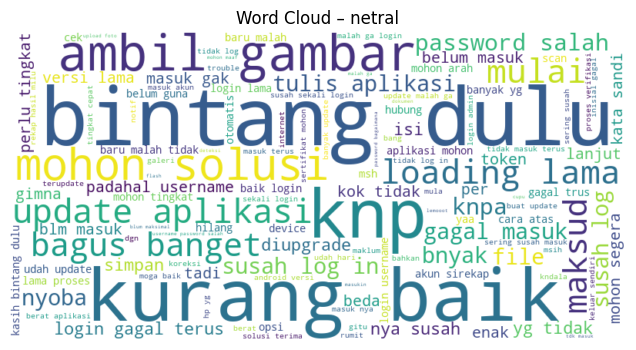

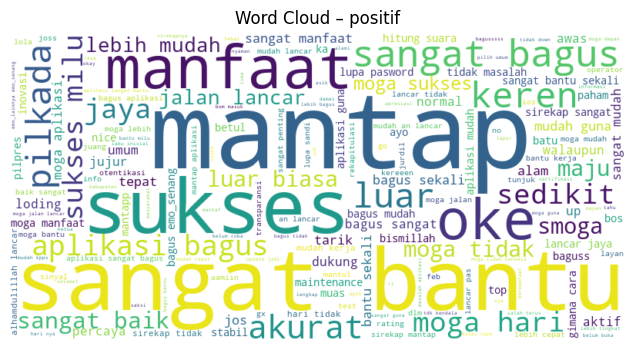

In [12]:
# === Muat hasil top terms yang sudah kamu simpan ===
vocab_top = pd.read_csv("artifacts/vocab_top_terms.csv")

# Hitung berapa banyak kelas tiap kata muncul
class_count = vocab_top.groupby("term")["class_"].nunique().reset_index(name="class_count")

# Ambil hanya kata yang muncul di satu kelas saja (unik per sentimen)
unique_terms = class_count.loc[class_count["class_count"] == 1, "term"]

# Filter DataFrame agar hanya berisi kata unik per kelas
filtered_vocab = vocab_top[vocab_top["term"].isin(unique_terms)]

# Simpan hasilnya
filtered_vocab.to_csv("artifacts/vocab_top_terms_filtered.csv", index=False)

for label, subset in filtered_vocab.groupby("class_"):
    freq = dict(zip(subset.term, subset.mean_tfidf))
    wc = WordCloud(width=800, height=400, background_color="white")
    wc.generate_from_frequencies(freq)
    
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud – {label}")
    plt.show()

In [13]:
import json
from pathlib import Path

# Hitung jumlah ulasan per sentimen (buat ditampilkan "2.840 ulasan" dll)
count_pos = int((df["sentiment_initial"] == "positif").sum())
count_net = int((df["sentiment_initial"] == "netral").sum())
count_neg = int((df["sentiment_initial"] == "negatif").sum())

def build_wc_payload(df_terms, max_words=50):
    """
    Ambil top N term, lalu normalisasi skor TF-IDF (0–1)
    biar nanti bisa dikonversi ke ukuran font di frontend.
    """
    df_small = df_terms.head(max_words).copy()
    
    max_score = df_small["mean_tfidf"].max()
    min_score = df_small["mean_tfidf"].min()
    denom = max_score - min_score if max_score != min_score else 1.0
    
    df_small["score_norm"] = (df_small["mean_tfidf"] - min_score) / denom
    
    return [
        {
            "text": row.term,
            "score": float(row.score_norm),      # 0..1
            "raw_score": float(row.mean_tfidf),  # opsional, kalau mau dipakai
        }
        for _, row in df_small.iterrows()
    ]

wc_data = {
    "summary": {
        "positif": count_pos,
        "netral": count_net,
        "negatif": count_neg,
    },
    "wordcloud": {
        "positif": build_wc_payload(top_pos, max_words=50),
        "netral":  build_wc_payload(top_net, max_words=50),
        "negatif": build_wc_payload(top_neg, max_words=50),
    },
}

Path("artifacts").mkdir(exist_ok=True)

with open("artifacts/wordcloud.json", "w", encoding="utf-8") as f:
    json.dump(wc_data, f, ensure_ascii=False, indent=2)

print("✅ wordcloud.json disimpan di artifacts/wordcloud.json")


✅ wordcloud.json disimpan di artifacts/wordcloud.json


### Visualize

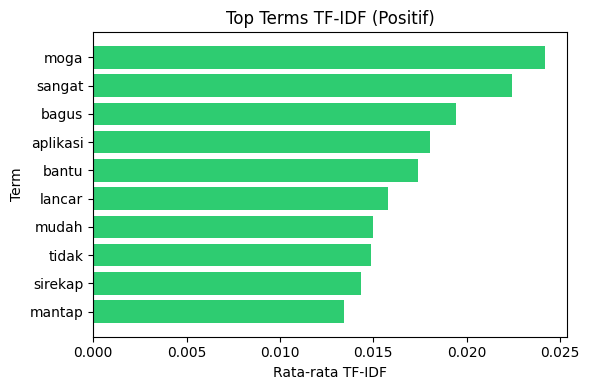

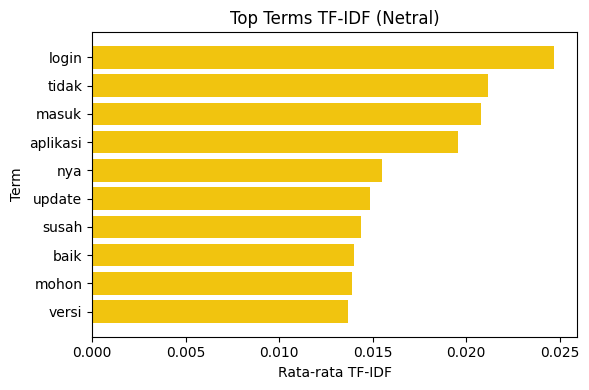

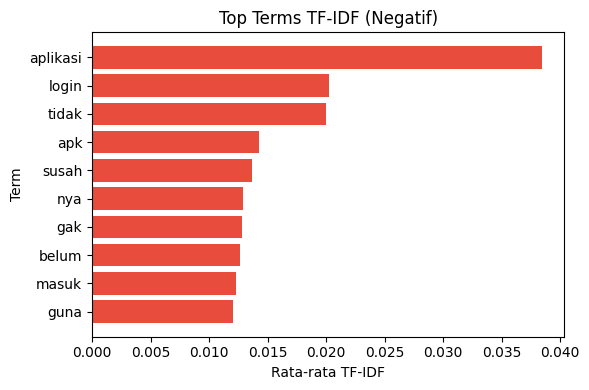

In [14]:
import matplotlib.pyplot as plt

def plot_top_terms(df_terms, kelas, warna):
    plt.figure(figsize=(6, 4))
    dfp = df_terms.head(10).iloc[::-1]  # ambil 10 term teratas, urutkan dari bawah agar tampil naik
    plt.barh(dfp["term"], dfp["mean_tfidf"], color=warna)
    plt.title(f"Top Terms TF-IDF ({kelas})")
    plt.xlabel("Rata-rata TF-IDF")
    plt.ylabel("Term")
    plt.tight_layout()
    plt.show()  # tampilkan langsung di cell

# tampilkan semua grafik di bawah cell ini
plot_top_terms(top_pos, "Positif", "#2ecc71")
plot_top_terms(top_net, "Netral", "#f1c40f")
plot_top_terms(top_neg, "Negatif", "#e74c3c")



## Naive Bayes

### Init

In [15]:
# Init
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import os

# Buat folder jika belum ada
os.makedirs("artifacts", exist_ok=True)
os.makedirs("images", exist_ok=True)



### Read File

In [16]:
# Read File
df = pd.read_csv("data/clean_reviews.csv")
print("Jumlah data:", len(df))
print(df.head(3))

# Pastikan label ada
if "sentiment_initial" not in df.columns:
    raise KeyError("Kolom 'sentiment_initial' tidak ditemukan.")


Jumlah data: 16600
                               reviewId              user  \
0  35fd099f-e115-4f0f-b95d-32de5f0fdd62       Bbirong Dan   
1  09c34494-6046-470a-a946-9a376616f682  syahrul ramadhan   
2  cecae6f3-b000-42b3-aaa0-b13bbb7bcafe     Khoirul Tamam   

                                         review_text  rating  thumbs_up  \
0  Aplikasi butut, herannya kpu dikasih waktu 5 t...       1        386   
1  Sebelumnya saya ingin mengapresiasi digitalisa...       2        658   
2  APLIKASI GAGAL. Suka nge bug, over akses bikin...       1        609   

  reviewCreatedVersion appVersion          review_date  replyContent  \
0                 2.32       2.32  2024-02-26 20:47:32           NaN   
1                 2.30       2.30  2024-02-01 12:45:55           NaN   
2                 2.41       2.41  2024-02-16 19:29:00           NaN   

   repliedAt sentiment_initial emoji_tokens emoji_emotion  \
0        NaN           negatif          NaN   tanpa_emoji   
1        NaN           n

### TF-IDF

In [17]:
tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,3),
    min_df=2,
    sublinear_tf=True,
    smooth_idf=True
)

X_tfidf = tfidf.fit_transform(df["clean_text"])
y = df["sentiment_initial"]

joblib.dump(tfidf, "artifacts/tfidf_vectorizer.pkl")

print("Dimensi TF-IDF:", X_tfidf.shape)


Dimensi TF-IDF: (16600, 30000)


### Oversampling

In [18]:
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_tfidf, y)

print("Distribusi setelah SMOTE:", Counter(y_bal))


Distribusi setelah SMOTE: Counter({'negatif': 13543, 'positif': 13543, 'netral': 13543})


### Split Data & Testing

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

print("Data train:", X_train.shape, "| Data test:", X_test.shape)


Data train: (32503, 30000) | Data test: (8126, 30000)


### Train Model (Multinomial NB)

In [20]:
params = {"alpha": [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0]}
nb = MultinomialNB()

# GridSearch di data train yang sudah di-oversample
grid = GridSearchCV(
    nb,
    params,
    cv=5,
    n_jobs=-1,
    scoring="f1_macro",
    verbose=1
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
joblib.dump(best_model, "artifacts/naive_bayes_optimized.pkl")

print(f"Model terbaik dengan alpha={grid.best_params_['alpha']}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Model terbaik dengan alpha=0.001


### Model Evaluate

In [21]:
y_pred = best_model.predict(X_test)
print("=== HASIL EVALUASI MODEL ===")
print(classification_report(y_test, y_pred, digits=2))

acc = accuracy_score(y_test, y_pred)
print(f"Akurasi: {acc*100:.2f}%")

# Simpan laporan ke file
with open("artifacts/classification_report.txt", "w") as f:
    f.write(classification_report(y_test, y_pred, digits=2))


=== HASIL EVALUASI MODEL ===
              precision    recall  f1-score   support

     negatif       0.91      0.89      0.90      2708
      netral       0.91      0.96      0.94      2709
     positif       0.91      0.88      0.90      2709

    accuracy                           0.91      8126
   macro avg       0.91      0.91      0.91      8126
weighted avg       0.91      0.91      0.91      8126

Akurasi: 91.07%


### Check Overfitting/ Underfitting

Akurasi Data Latih : 0.9298
Akurasi Data Uji   : 0.9107
Model fit dengan baik (selisih <3%)


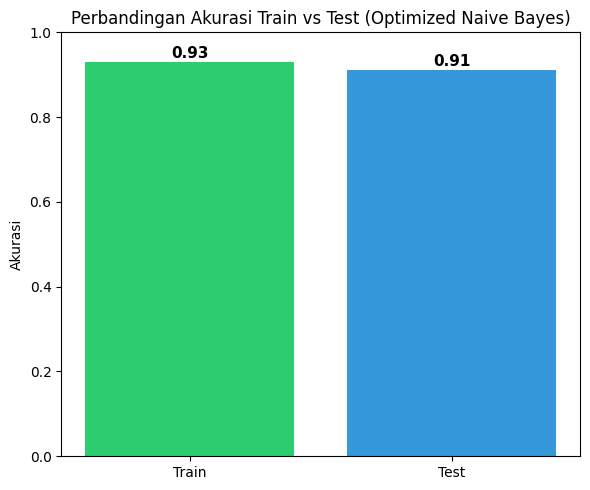

In [22]:
acc_train = best_model.score(X_train, y_train)
acc_test = best_model.score(X_test, y_test)

print(f"Akurasi Data Latih : {acc_train:.4f}")
print(f"Akurasi Data Uji   : {acc_test:.4f}")

if abs(acc_train - acc_test) < 0.03:
    print("Model fit dengan baik (selisih <3%)")
elif acc_train > acc_test:
    print("Model sedikit overfit (train > test)")
else:
    print("Model underfit (train < test)")

# Visualisasi perbandingan
plt.figure(figsize=(6,5))
bars = plt.bar(["Train", "Test"], [acc_train, acc_test],
               color=["#2ecc71", "#3498db"])
plt.title("Perbandingan Akurasi Train vs Test (Optimized Naive Bayes)")
plt.ylim(0, 1)
for bar, acc in zip(bars, [acc_train, acc_test]):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.01,
             f"{acc:.2f}", ha="center", fontsize=11, weight="bold")

plt.ylabel("Akurasi")
plt.tight_layout()
plt.savefig("images/akurasi_train_test.png", dpi=200)
plt.show()


### Confusion Matrix

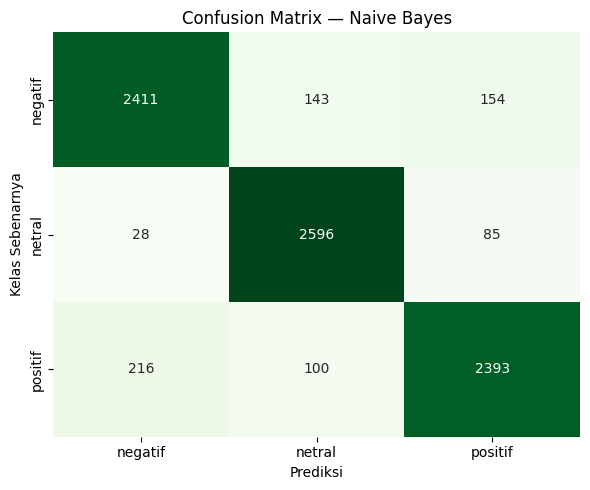

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
cm_df = pd.DataFrame(cm, index=best_model.classes_, columns=best_model.classes_)

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix — Naive Bayes")
plt.xlabel("Prediksi")
plt.ylabel("Kelas Sebenarnya")
plt.tight_layout()
plt.savefig("images/confusion_matrix_nb.png", dpi=200)
plt.show()


### Manual Prediction

In [24]:

samples = [
    # Positif
    "Aplikasi sangat membantu dan mudah digunakan, terima kasih KPU.",
    "Tampilan simpel, proses rekap jadi lebih cepat dan praktis.",
    "Versi terbaru jauh lebih stabil, tidak ada error saat input data TPS.",

    # Netral
    "Update versi terbaru sudah tersedia di Play Store.",
    "Mohon informasi jadwal maintenance aplikasi SIREKAP.",
    "Saya baru pertama kali menggunakan aplikasi ini untuk rekap TPS.",

    # Negatif
    "Tidak bisa login, selalu error padahal jaringan bagus.",
    "Aplikasi sering crash saat input data, sangat mengganggu.",
    "Lambat sekali, setiap buka menu selalu loading terus.",

    # Tricky
    "Agak lambat tapi masih bisa digunakan untuk input data TPS.",
    "Awalnya sering error, tapi setelah update sudah lebih baik.",
    "Tidak terlalu buruk, tapi perlu banyak perbaikan agar lebih stabil."
]

# pakai preprocess yang sama
samples_clean = [simple_preprocess(s) for s in samples]

X_manual = tfidf.transform(samples_clean)
probas    = best_model.predict_proba(X_manual)
raw_preds = best_model.predict(X_manual)

classes = best_model.classes_
print("Kelas model:", classes)
print("="*70)

for raw, clean, raw_label, prob in zip(samples, samples_clean, raw_preds, probas):

    print(f"RAW        : {raw}")
    print(f"CLEAN      : {clean}")
    print(f"PRED    : {raw_label}")
    print(f"PROBA      : {prob}")
    print("-"*70)


Kelas model: ['negatif' 'netral' 'positif']
RAW        : Aplikasi sangat membantu dan mudah digunakan, terima kasih KPU.
CLEAN      : aplikasi sangat bantu mudah guna terima kasih kpu
PRED    : positif
PROBA      : [5.12175623e-04 5.12010366e-05 9.99436623e-01]
----------------------------------------------------------------------
RAW        : Tampilan simpel, proses rekap jadi lebih cepat dan praktis.
CLEAN      : tampil simpel proses rekap jadi lebih cepat praktis
PRED    : positif
PROBA      : [3.04980807e-02 8.14351158e-05 9.69420484e-01]
----------------------------------------------------------------------
RAW        : Versi terbaru jauh lebih stabil, tidak ada error saat input data TPS.
CLEAN      : versi baru jauh lebih stabil tidak error input data tps
PRED    : netral
PROBA      : [0.03761646 0.95512139 0.00726215]
----------------------------------------------------------------------
RAW        : Update versi terbaru sudah tersedia di Play Store.
CLEAN      : update versi ba

In [25]:
# --- Jumlah kata yang teranalisis ---

# 1) Jumlah kata unik (fitur) yang dianalisis oleh TF-IDF
vocab = tfidf.get_feature_names_out()
n_unique_terms = len(vocab)
print(f"Jumlah kata unik yang dianalisis TF-IDF: {n_unique_terms:,}")

# 2) Total token (jumlah kata) setelah preprocessing
df["word_count"] = df["clean_text"].str.split().str.len()
total_tokens = df["word_count"].sum()
print(f"Total token (kata) setelah preprocessing: {total_tokens:,}")
print(df[["clean_text", "word_count"]].head())





Jumlah kata unik yang dianalisis TF-IDF: 30,000
Total token (kata) setelah preprocessing: 185,031
                                          clean_text  word_count
0  aplikasi butut heran kpu kasih waktu tahun bua...          53
1  belum apresiasi digitalisasi dlm aspek yg kait...          56
2  aplikasi gagal suka nge bug over akses bikin l...          40
3  lebih mampu server si seperti aplikasi jauh ke...          46
4  apk apa kalo bikin mah jangan tengah tengah ka...          39


In [26]:
# --- Distribusi label sentimen ---

label_order = ["positif", "netral", "negatif"]

label_counts = df["sentiment_initial"].value_counts().reindex(label_order)
label_pct    = (label_counts / label_counts.sum() * 100).round(2)

label_summary = pd.DataFrame({
    "jumlah": label_counts,
    "persentase (%)": label_pct
})

print(label_summary)


                   jumlah  persentase (%)
sentiment_initial                        
positif              2201           13.26
netral                856            5.16
negatif             13543           81.58


In [27]:
# --- Distribusi rating 1–5 ---

rating_counts = df["rating"].value_counts().sort_index()
rating_pct    = (rating_counts / rating_counts.sum() * 100).round(2)

rating_summary = pd.DataFrame({
    "rating": rating_counts.index,
    "jumlah": rating_counts.values,
    "persentase (%)": rating_pct.values
})

print(rating_summary)


   rating  jumlah  persentase (%)
0       1   12207           73.54
1       2    1336            8.05
2       3     856            5.16
3       4     386            2.33
4       5    1815           10.93


In [28]:
# --- Definisi isu (berdasarkan keyword di clean_text) ---
issue_definitions = [
    {"id": "login", "title": "Tidak bisa login", "keywords": ["login", "log in", "masuk"]},
    {"id": "error_open", "title": "Error saat membuka aplikasi", "keywords": ["error", "gagal buka", "tidak bisa dibuka"]},
    {"id": "slow", "title": "Lambat memuat data", "keywords": ["lemot", "lambat", "loading", "lama"]},
    {"id": "sync", "title": "Gagal sinkronisasi", "keywords": ["sinkron", "sinkronisasi", "sync"]},
    {"id": "force_close", "title": "Aplikasi force close", "keywords": ["force close", "keluar sendiri", "tutup sendiri", "crash"]},
]

df_neg = df[df["sentiment_initial"] == "negatif"].copy()
n_neg = len(df_neg)

top_issues = []

for issue in issue_definitions:
    # gabung keywords jadi regex OR
    pattern = "|".join(issue["keywords"])
    mask = df_neg["clean_text"].str.contains(pattern, na=False)
    count = int(mask.sum())
    percentage = float(round(count / n_neg * 100, 1)) if n_neg > 0 else 0.0
    
    top_issues.append({
        "id": issue["id"],
        "title": issue["title"],
        "count": count,
        "percentage": percentage,
    })

# urutkan berdasarkan count, ambil 5 teratas
top_issues = sorted(top_issues, key=lambda x: x["count"], reverse=True)[:5]

top_issues


[{'id': 'login',
  'title': 'Tidak bisa login',
  'count': 3977,
  'percentage': 29.4},
 {'id': 'slow',
  'title': 'Lambat memuat data',
  'count': 865,
  'percentage': 6.4},
 {'id': 'error_open',
  'title': 'Error saat membuka aplikasi',
  'count': 610,
  'percentage': 4.5},
 {'id': 'force_close',
  'title': 'Aplikasi force close',
  'count': 86,
  'percentage': 0.6},
 {'id': 'sync', 'title': 'Gagal sinkronisasi', 'count': 13, 'percentage': 0.1}]